https://qiskit.org/documentation/tutorials/chemistry/03_ground_state_solvers.html

このチュートリアルでは、Qiskit Chemistryの基底状態計算インターフェースについて説明します。目標は分子ハミルトニアンの基底状態を計算することです。このハミルトニアンは電子的または振動的なものである可能性があります。ハミルトニアンの準備についての詳細は、電子構造とバイブロニック構造のチュートリアルをチェックしてください。

最初のステップは、分子系を定義することです。以下では、水素分子の電子部分を求めます。

In [2]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType

molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)

## The Solver

そこで、ソルバーを定義する必要があります。ソルバーとは、基底状態が計算されるアルゴリズムのことです。

まず、純粋に古典的な例から始めましょう：NumPy最小値ソルバーです。このアルゴリズムはハミルトニアンを正確に対角化します。スケールは悪いですが、小さなシステムで量子アルゴリズムの結果を確認するために使用することができます。

In [3]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

基底状態を見つけるために、我々はまた、VQE（Variational Quantum Eigensolver）アルゴリズムを使用することができます。VQEアルゴリズムは、次の図に示すように、古典的なコンピュータと量子コンピュータの間で情報を交換することによって動作します。

VQEソルバーを初期化してみましょう。

In [4]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.chemistry.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCSDFactory

vqe_solver = VQEUCCSDFactory(QuantumInstance(BasicAer.get_backend('statevector_simulator')))


VQEソルバーを定義するためには、2つの重要な要素が必要である。

変分形式: ここでは、ユニタリー・カップルド・クラスター(UCC)を用います(例えば、[Physical Review A 98.2 (2018): 022322]を参照してください)。これは化学標準なので、UCCを使ったVQEの高速な初期化を可能にするファクトリが既に利用可能です。デフォルトでは、すべてのシングル励起とダブル励起を使用します。しかし、励起の種類(S, D, SD)や他のパラメータを選択することができます。

初期状態：クビットの初期状態。上記のファクトリーでは、クビットはハートリーフォック（電子構造チュートリアルを参照）初期状態で初期化されています（占有MOに対応するクビットは｜1⟩で、仮想MOに対応するクビットは｜0⟩です）。

バックエンド：これは、上の図の右の部分が実行される量子マシンです。ここでは、完全な量子エミュレータ（statevector_simulator）を使用します。

また、利用可能な変分法や初期状態を使用することもできますし、独自の定義も可能です。例えば、以下のようになります。

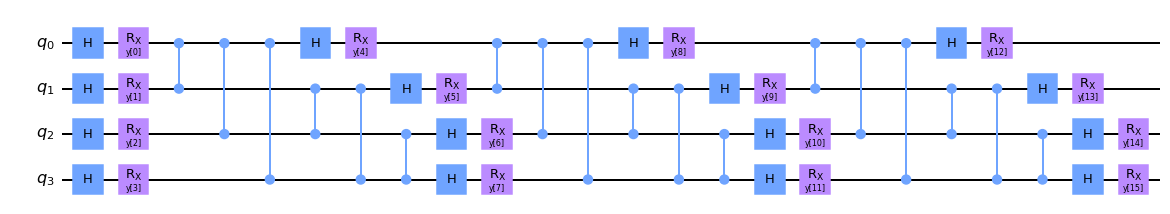

In [10]:
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import TwoLocal

num_qubits = 4
tl_circuit = TwoLocal(num_qubits, ['h', 'rx'], 'cz',
                      entanglement='full', reps=3, parameter_prefix = 'y')

tl_circuit.draw(output = 'mpl')

In [11]:
another_solver = VQE(var_form = tl_circuit,
                     quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator')))

## The calculation and results

これで計算を実行する準備が整いました。

In [6]:
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver

calc = GroundStateEigensolver(transformation, vqe_solver)
res = calc.solve(driver)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894866]
    - computed part:      [0.0  0.0  1.38894866]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.00000004]  Total: 0.00000004
                 (debye): [0.0  0.0  0.0000001]  Total: 0.0000001
 


VQEの結果をNumPyの正確なソルバーと比較して、一致していることを確認することができます。

In [7]:
calc = GroundStateEigensolver(transformation, numpy_solver)
res = calc.solve(driver)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


## Using a filter function

時には、ハミルトニアンの真の基底状態は、ヒルベルト空間の異なる対称性セクタにあるため、興味を持たれないことがあります。この場合、NumPy固有値ソルバーは、例えば正しい粒子数を持つ固有状態のみを返すためのフィルタ関数を取ることができます。これは、ハミルトニアンの真の基底状態が真空状態である振動構造計算の場合に特に重要です。粒子数をチェックするためのデフォルトのフィルタ関数は、さまざまな変換に実装されており、以下のように使用できます。

In [9]:
from qiskit.chemistry.drivers import GaussianForcesDriver
from qiskit.chemistry.algorithms.ground_state_solvers import NumPyMinimumEigensolverFactory
from qiskit.chemistry.transformations import (BosonicTransformation,
                                              BosonicTransformationType,
                                              BosonicQubitMappingType)

driver = GaussianForcesDriver(logfile='aux_files/CO2_freq_B3LYP_ccpVDZ.log')
bosonic_transformation = BosonicTransformation(qubit_mapping=BosonicQubitMappingType.DIRECT,
                                               transformation_type=BosonicTransformationType.HARMONIC,
                                               basis_size=2,
                                               truncation=2)

solver_without_filter = NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
solver_with_filter = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)

gsc_wo = GroundStateEigensolver(bosonic_transformation, solver_without_filter)
result_wo = gsc_wo.solve(driver)

gsc_w = GroundStateEigensolver(bosonic_transformation, solver_with_filter)
result_w = gsc_w.solve(driver)

print(result_wo)
print('\n\n')
print(result_w)

=== GROUND STATE ENERGY ===
 
* Vibronic ground state energy (cm^-1): -0j
The number of occupied modals is
- Mode 0: [0.0, 0.0, 0.0, 0.0]



=== GROUND STATE ENERGY ===
 
* Vibronic ground state energy (cm^-1): (2536.48797636242+0j)
The number of occupied modals is
- Mode 0: [1.0, 1.0, 1.0, 1.0]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/chemistry/results/vibronic_structure_result.py:73: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  format(round(self.computed_vibronic_energies[0], 12)))
/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/chemistry/results/vibronic_structure_result.py:73: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  format(round(self.computed_vibronic_energies[0], 12)))
